# SNAI/ZEB Remove

Take fibroblast(-like) models, and peaks with SNAI/ZEB motifs and remove them to see effect on predicted counts.

In [1]:
import numpy as np

In [2]:
import keras
import tensorflow as tf
import pyfaidx
import math
import pandas as pd
import tqdm

Using TensorFlow backend.
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/s

In [3]:
import sys

from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/mtbatchgen/example/")
from losses import MultichannelMultinomialNLL, multinomial_nll

In [4]:
# local
from importlib import reload
import one_hot
reload(one_hot)

<module 'one_hot' from '/users/surag/kundajelab/scATAC-reprog/src/analysis/20210322_BPNet_synthetic/one_hot.py'>

In [5]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/cluster_idx8/2020-11-05_07_17_32/SoGro3.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/cluster_idx2/2020-11-05_03_48_37/QAdERE.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/cluster_idx4/2021-02-09_18_23_03/0pYOdc.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/cluster_idx1/2020-11-05_03_48_37/dRMWWH.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20201105_all_peaks_filt256_in2346_out2000/cluster_idx5/2020-11-05_03_48_37/KR1GbF.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/cluster_idx16/2020-11-06_00_34_22/Z21ucK.h5")

    model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx5/2021-04-14_18_11_26/nqv4wJ.h5")

In [6]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

In [7]:
motif_hits = pd.read_csv("./data/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/ZEB.cluster_idx5.bed", 
                           sep='\t',
                           names=["chr", "start", "end", "name", "score", "strand", "family", "x"])
motif_hits.head()

,chr,start,end,name,score,strand,family,x
0,chr1,858753,858759,SNAI2,10.6258,+,ZEB1_HUMAN.H11MO.0.A,2
1,chr1,1013591,1013597,SNAI2,9.1192,+,ZEB1_HUMAN.H11MO.0.A,4
2,chr1,1059779,1059785,SNAI2,9.2534,+,ZEB1_HUMAN.H11MO.0.A,2
3,chr1,1064398,1064404,SNAI2,9.4406,+,ZEB1_HUMAN.H11MO.0.A,2
4,chr1,1218113,1218119,SNAI2,8.5300,-,ZEB1_HUMAN.H11MO.0.A,4


In [8]:
# motif_hits = pd.DataFrame({"chr":["chr16", "chr16", "chr1"], 
#                            "start":[68737211, 68737262, 58784624], 
#                            "end":[68737217, 68737268, 58784630],
#                           "strand":["+", "+", "+"]})
# motif_hits  

In [9]:
first_seq = motif_hits.iloc[0]
hg38[first_seq['chr']][first_seq['start']:first_seq['end']]

>chr1:858754-858759
CAGGTG

In [10]:
# hg38[first_seq['chr']][first_seq['start']:first_seq['end']]==first_seq['seq']

In [11]:
motif_hits.shape

(6686, 8)

In [12]:
MODEL_INP_LEN = model.input_shape[0][1]
print(MODEL_INP_LEN)

2346


In [13]:
BATCH_SIZE = 128

# predict on raw sequence
raw_pred_counts = []

for i in tqdm.tqdm(range(math.ceil(motif_hits.shape[0]/BATCH_SIZE))):
    cur_seqs = motif_hits[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in cur_seqs.iterrows():
        mid = (r['start']+r['end'])//2
        cur_raw_seqs.append(str(hg38[r['chr']][mid-(MODEL_INP_LEN//2):mid+(MODEL_INP_LEN//2)]))
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    raw_pred_counts.append(cur_pred)
    
raw_pred_counts = np.vstack(raw_pred_counts).ravel()

100%|██████████| 53/53 [00:18<00:00,  2.89it/s]


In [27]:
BATCH_SIZE = 128

# replace with canonical motif and predict
synth_pred_counts = []

for i in tqdm.tqdm(range(math.ceil(motif_hits.shape[0]/BATCH_SIZE))):
    cur_seqs = motif_hits[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in cur_seqs.iterrows():
        mid = (r['start']+r['end'])//2
        cur_raw_seqs.append(str(hg38[r['chr']][mid-(MODEL_INP_LEN//2):mid+(MODEL_INP_LEN//2)]))
        
        motif_start = MODEL_INP_LEN//2 - (mid-r['start'])
        motif_end = MODEL_INP_LEN//2 + (r['end']-mid)
        
        # replace with random (or something else)
        # random: ACGTAGAATACTGTG
        if r['strand'] == "+":
            replacement = "CAGCTG"
        else:
            replacement = "CAGCTG" 
        
        cur_raw_seqs[-1] = cur_raw_seqs[-1][:motif_start] +  replacement + cur_raw_seqs[-1][motif_end:] 
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    synth_pred_counts.append(cur_pred)
    
synth_pred_counts = np.vstack(synth_pred_counts).ravel()

100%|██████████| 53/53 [00:16<00:00,  3.27it/s]


In [28]:
np.median(synth_pred_counts)

6.936553

In [29]:
np.median(raw_pred_counts)

6.549999

In [30]:
np.median(np.exp(synth_pred_counts-raw_pred_counts))

1.3452382

In [31]:
np.median(synth_pred_counts-raw_pred_counts)

0.29657102

In [32]:
import scipy.stats

In [33]:
scipy.stats.ttest_rel(raw_pred_counts, synth_pred_counts)

Ttest_relResult(statistic=-91.86638341578866, pvalue=0.0)

In [34]:
import matplotlib.pyplot as plt

<AxesSubplot:>

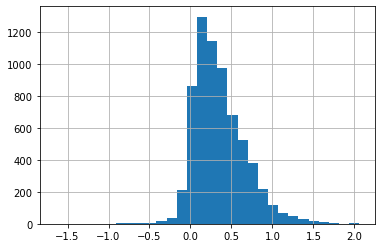

In [35]:
plt.rcParams["figure.figsize"] = (6,4)
pd.Series(synth_pred_counts - raw_pred_counts).hist(bins=30)

In [36]:
from scipy.stats import gaussian_kde

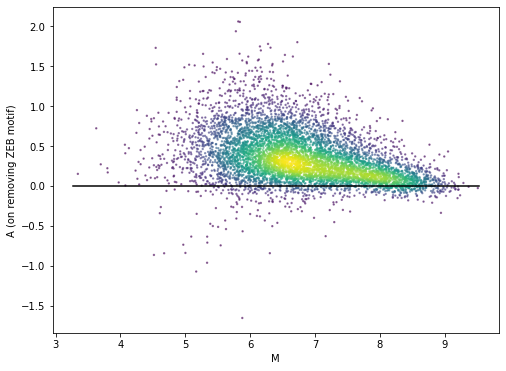

In [37]:
plt.rcParams["figure.figsize"] = (8,6)

x = (raw_pred_counts+synth_pred_counts)/2
y = (synth_pred_counts-raw_pred_counts)
xy=np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, s=2, c=z, alpha=0.5)
plt.plot([min(raw_pred_counts), max(raw_pred_counts)], [0,0], '-k', label='y=2x+1')
plt.xlabel("M")
plt.ylabel("A (on removing ZEB motif)")
plt.savefig("image.jpg", dpi=300)

In [49]:
def softmax(x):
    norm_x = x - np.mean(x)
    return np.exp(norm_x)/np.sum(np.exp(norm_x))

### CDH1 promoter

3 ZEB motifs at promoter :

```
chr16:68737211-68737217 
chr16:68737262-68737268	
chr16:68737312-68737318
```

In [38]:
import pyBigWig

In [39]:
f = pyBigWig.open("/oak/stanford/groups/akundaje/surag/projects//scATAC-reprog/clusters/20201020_n62402/bigwigs/cluster_idx5.bw")

In [40]:
# f.close()

In [39]:
from copy import deepcopy
import scipy

In [40]:
start1 = 68737211
start2 = 68737262
start3 = 68737312

In [41]:
midpt = 68737261
origseq = str(hg38["chr16"][midpt-(MODEL_INP_LEN//2):midpt+(MODEL_INP_LEN//2)])

In [42]:
idx1 = (MODEL_INP_LEN//2 + (start1-midpt))
idx2 = (MODEL_INP_LEN//2 + (start2-midpt))
idx3 = (MODEL_INP_LEN//2 + (start3-midpt))

In [43]:
print(origseq[idx1:idx1+6],
      origseq[idx2:idx2+6],
      origseq[idx3:idx3+6])

CAGGTG CACCTG CACCTG


In [44]:
alt1seq = origseq[:idx1] + "CGAAGA" + origseq[idx1+6:]
alt2seq = origseq[:idx2] + "CGAAGA" + origseq[idx2+6:]
alt3seq = origseq[:idx3] + "CGAAGA" + origseq[idx3+6:]

alt4seq = deepcopy(alt1seq)
alt4seq = alt4seq[:idx2] + "CGAAGA" + alt4seq[idx2+6:]

alt5seq = deepcopy(alt4seq)
alt5seq = alt5seq[:idx3] + "CGAAGA" + alt5seq[idx3+6:]

In [45]:
cur_raw_seqs = one_hot.dna_to_one_hot([origseq, alt1seq, alt2seq, alt3seq, alt4seq, alt5seq])

In [46]:
prof, cts = model.predict([cur_raw_seqs, 
               np.zeros((cur_raw_seqs.shape[0],1)), 
               np.zeros((cur_raw_seqs.shape[0],2000,2))])

In [47]:
cts

array([[6.6561313],
       [7.223245 ],
       [7.253742 ],
       [6.8386574],
       [7.7175784],
       [7.8772373]], dtype=float32)

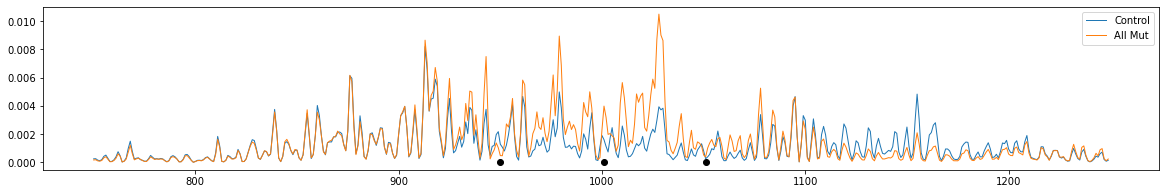

In [50]:
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(range(2000)[750:1250], (softmax(prof[0]))[750:1250], linewidth=1, label="Control")
# plt.plot(range(2000)[750:1250], (softmax(prof[1]))[750:1250], linewidth=1, label="Mut1")
# plt.plot(range(2000)[750:1250], (softmax(prof[2]))[750:1250], linewidth=1, label="Mut2")
# plt.plot(range(2000)[750:1250], (softmax(prof[3]))[750:1250], linewidth=1, label="Mut3")
plt.plot(range(2000)[750:1250], (softmax(prof[5]))[750:1250], linewidth=1, label="All Mut")
plt.scatter(1000+(start1-midpt), 0, c='k')
plt.scatter(1000+(start2-midpt), 0, c='k')
plt.scatter(1000+(start3-midpt), 0, c='k')
plt.legend()

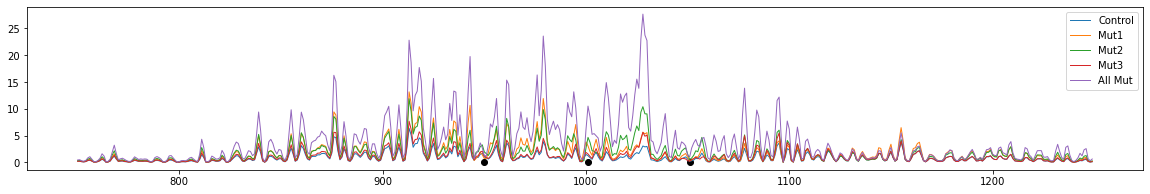

In [51]:
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(range(2000)[750:1250], (softmax(prof[0])*np.exp(cts[0]))[750:1250], linewidth=1, label="Control")
plt.plot(range(2000)[750:1250], (softmax(prof[1])*np.exp(cts[1]))[750:1250], linewidth=1, label="Mut1")
plt.plot(range(2000)[750:1250], (softmax(prof[2])*np.exp(cts[2]))[750:1250], linewidth=1, label="Mut2")
plt.plot(range(2000)[750:1250], (softmax(prof[3])*np.exp(cts[3]))[750:1250], linewidth=1, label="Mut3")
plt.plot(range(2000)[750:1250], (softmax(prof[5])*np.exp(cts[5]))[750:1250], linewidth=1, label="All Mut")
plt.scatter(1000+(start1-midpt), 0, c='k')
plt.scatter(1000+(start2-midpt), 0, c='k')
plt.scatter(1000+(start3-midpt), 0, c='k')
plt.legend()

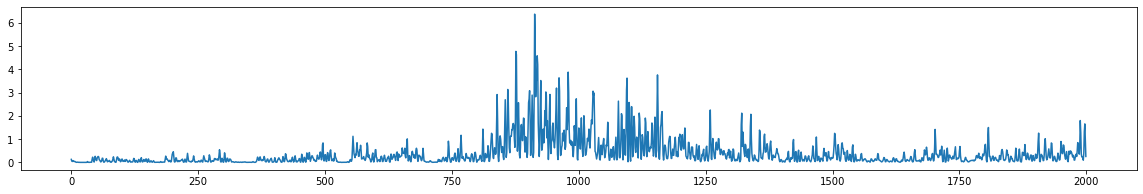

In [52]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(2000), softmax(prof[0])*np.exp(cts[0]))

In [53]:
plt.rcParams["figure.figsize"] = (20,3)
smoothed_observed = scipy.ndimage.gaussian_filter1d(np.nan_to_num(f.values("chr16", 68737261 - 1000, 68737261+1000)), 2)
plt.plot(range(2000), smoothed_observed)

NameError: name 'f' is not defined

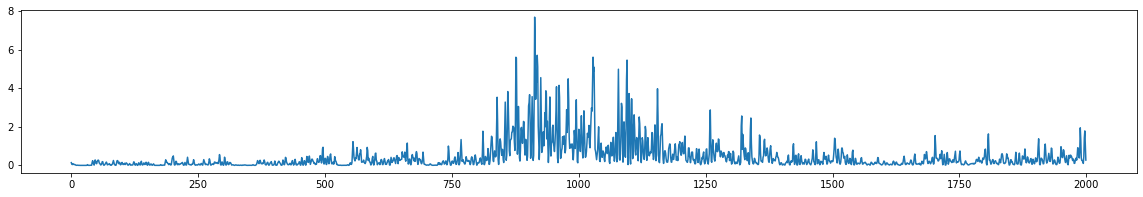

In [54]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(2000), softmax(prof[3])*np.exp(cts[3]))

In [58]:
np.nansum(f.values("chr1", 68737261 - 1000, 68737261+1000)) 

0.0

In [56]:
from shaputils import *
import shap

In [57]:
weightedsum_meannormed_logits = get_weightedsum_meannormed_logits(model)

profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
        ([model.input[0], model.input[1]],
         tf.reduce_sum(model.outputs[1], axis=-1)),
        shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
        ([model.input[0], model.input[2]], weightedsum_meannormed_logits),
        shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

In [58]:
X = cur_raw_seqs
counts_shap_scores = profile_model_counts_explainer.shap_values(
        [X, np.zeros((X.shape[0], 1))], progress_message=100)
projected_shap_scores = np.multiply(X, counts_shap_scores[0])

Done 0 examples of 6
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [59]:
# profile_shap_scores = profile_model_profile_explainer.shap_values(
#         [X, np.zeros((X.shape[0], 2000, 2))], progress_message=100)
# projected_shap_scores = np.multiply(X, profile_shap_scores[0])

In [60]:
from modisco.visualization import viz_sequence

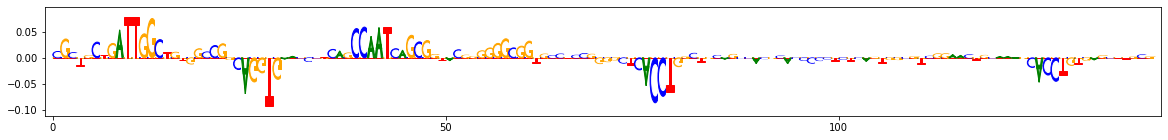

In [61]:
viz_sequence.plot_weights(projected_shap_scores[0][1100:1240], subticks_frequency=50)

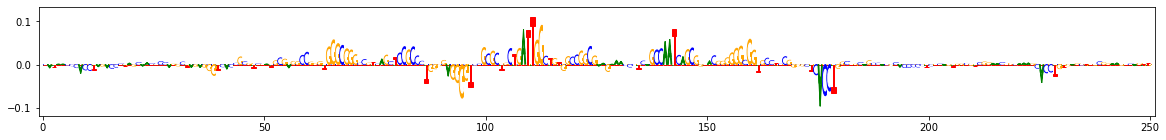

In [64]:
viz_sequence.plot_weights(projected_shap_scores[1][1000:1250], subticks_frequency=50)

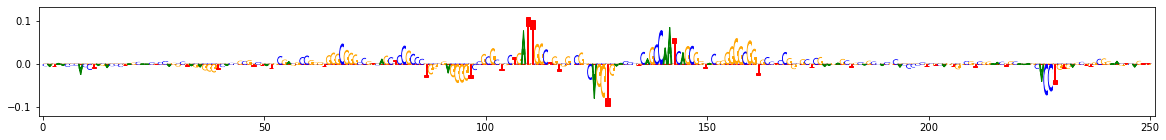

In [65]:
viz_sequence.plot_weights(projected_shap_scores[2][1000:1250], subticks_frequency=50)

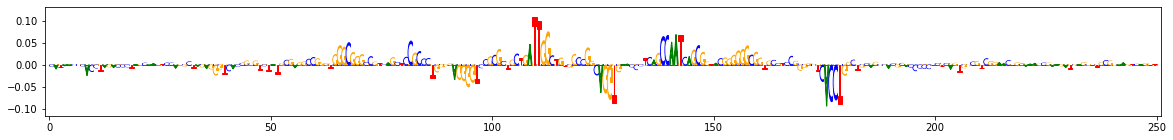

In [66]:
viz_sequence.plot_weights(projected_shap_scores[3][1000:1250], subticks_frequency=50)

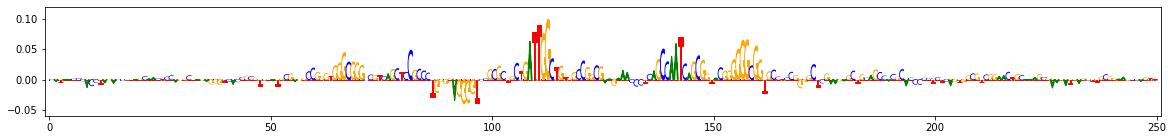

In [67]:
viz_sequence.plot_weights(projected_shap_scores[-1][1000:1250], subticks_frequency=50)

[<matplotlib.lines.Line2D at 0x7f0d4e257290>]

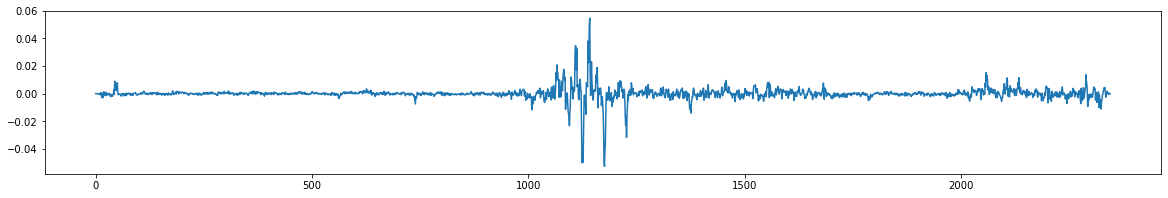

In [260]:
plt.plot(np.sum(projected_shap_scores[0],-1))